## Leela Mahesh Kodi (U28275523)
## Aakesh Kumar Murala (U63411601)

# Unit 2 Assessment

In this assignment, we will focus on airline incidents. The data set for this assignment includes information on the cost of bird strikes. Use this data set to see if you can predict the cost of a bird strike (i.e., the `Total Cost` column in the data set) based on the attributes of the incident. This is important because this model can make a cost prediction as soon as a bird strike incident happens.

## Description of Variables

The description of variables are provided in "Airline - Data Dictionary.docx"

## Goal

Use the **airline.csv** data set and build models to predict **Total Cost**.

**Be careful: this is a REGRESSION task**

## Submission:

Please save and submit this Jupyter notebook file. The correctness of the code matters for your grade. **Readability and organization of your code is also important.** You may lose points for submitting unreadable/undecipherable code. Therefore, use markdown cells to create sections, and use comments where necessary.


## Important hints:

* This assignment requires you to work with a text-based column in addition to regular numeric/categorical columns. So you will have to pay attention to your pipelines during data processing.
* You can do your data prep before or after the train/test split. Regardless, you should use train_test_split only once. If you find yourself using it twice, it means you are doing something wrong.
* Recommended approach: 
    * import the data and perform the train/test split - like we always do. 
    * identify the names of numeric, categorical, feature engineered, and text columns - like we always do
    * create individual pipelines for each type of column - like we always do. For the text pipeline, I would recommend the TFIDF Vectorizer with SVDs. Though, you can also use TFIDF Vectorizer with top N terms (without SVDs).
    * combine all pipelines using the column transformer - like we always do 

# Section 1: 

## Data Prep (5 points)

In [332]:
# Common imports
import numpy as np
import pandas as pd
np.random.seed(42)

In [333]:
# Importing the data set:
air_line = pd.read_csv("airline.csv")
air_line.head()

,Aircraft,Number_Objects,Engines,Origin State,Phase,Description,Object Size,Weather,Warning,Altitude,Total Cost
0,PA,37,1.0,Florida,Descent,"BIRD, BROWN BIRD. A/C WAS DESCENDING INTO PATT...",Large,No Cloud,N,1500.0,690
1,C,43,1.0,Florida,Approach,BIRD SHATTERED L SIDE OF WINDHSLD. STUDENT REC...,Large,No Cloud,Y,2000.0,570
2,B-737,71,2.0,Oklahoma,Climb,MEDIUM SIZED BLACK BIRDS. CONTRACT MX INSPN OF...,Medium,No Cloud,N,1100.0,1027
3,Airbus,29,2.0,Wisconsin,Approach,"ID BY SMITHSONIAN, FAA 3881. DNA. 2 CRACKS IN ...",Large,No Cloud,Y,200.0,77479
4,B-737,32,2.0,Texas,Approach,BIRD SEEN AND HEARD THAT STRUCK RADOME. UPON I...,Small,No Cloud,N,1000.0,411


In [334]:
air_line.shape

(1207, 11)

### Splitting the data into Train and Test

In [335]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(air_line, test_size=0.3)

In [336]:
train.shape

(844, 11)

In [337]:
test.shape

(363, 11)

#### By looking at the histogram of Total cost values of train and test set below, we can say that the totat cost data values are skewed and we may expect a difference between Model train and test RMSE scores

<Axes: >

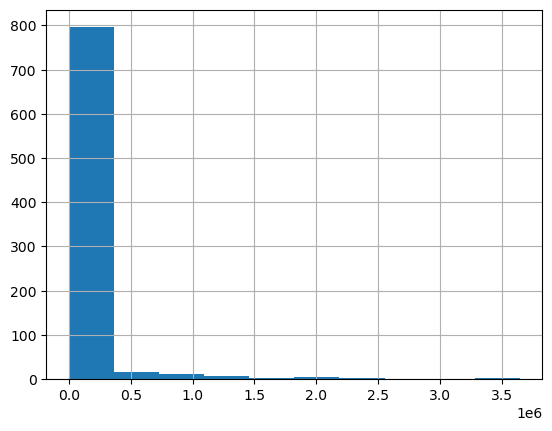

In [338]:
train['Total Cost'].hist(bins=10)

<Axes: >

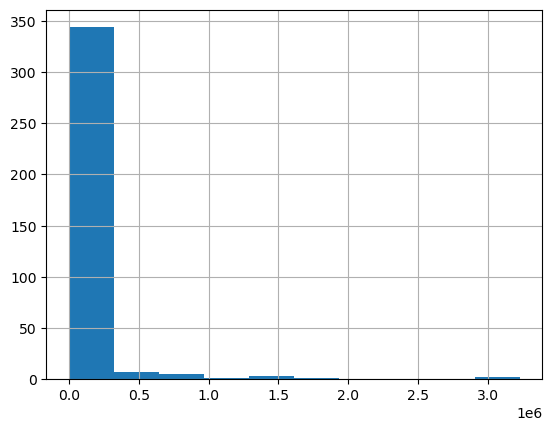

In [339]:
test['Total Cost'].hist(bins=10)

### Checking for missing values

In [340]:
train.isna().sum()

Aircraft           0
Number_Objects     0
Engines           21
Origin State      14
Phase             10
Description       44
Object Size       10
Weather            0
Warning           10
Altitude          10
Total Cost         0
dtype: int64

In [341]:
test.isna().sum()

Aircraft           0
Number_Objects     0
Engines            8
Origin State       4
Phase              4
Description       12
Object Size        4
Weather            0
Warning            4
Altitude           4
Total Cost         0
dtype: int64

#### Replacing the  'Warning' column values of Y & N with 1 & 0 as i want to make it as Binary Column

In [342]:
# Replace 'Y' with 1 and 'N' with 0 in the 'Warning' column in train set
train['Warning'] = train['Warning'].replace({'Y': 1, 'N': 0})

In [343]:
# Replace 'Y' with 1 and 'N' with 0 in the 'Warning' column in test set
test['Warning'] = test['Warning'].replace({'Y': 1, 'N': 0})

#### Filling the missing values in 'Warning', 'Engines' and 'Description' column of train and test set

In [344]:
# filling missing values in the 'Warning' column with the one value in train set

train['Warning'].fillna(1, inplace=True)

# filling missing values in the 'Engines' column with the one value in train set

train['Engines'].fillna(1, inplace=True)

# filling missing values in the 'Description' column with a empty string in train set

train['Description'].fillna('', inplace=True)

In [345]:
# filling missing values in the 'Warning' column with the one value in test set

test['Warning'].fillna(1, inplace=True)

# filling missing values in the 'Engines' column with the one value in test set

test['Engines'].fillna(1, inplace=True)

# filling missing values in the 'Description' column with a empty string in test set

test['Description'].fillna('', inplace=True)

## Data Preparation Using PipeLine

In [346]:
# Imports:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import FunctionTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD

### Separate the Total Cost column, which is the target variable as we don't transform the target variable

In [347]:
# Separate the target variable and input variables
train_target = train[['Total Cost']]
test_target = test[['Total Cost']]

train_input = train.drop(['Total Cost'], axis=1)
test_input = test.drop(['Total Cost'], axis=1)

## Feature Engineering (1 point)

Create one NEW feature from existing data. You either transform a single variable, or create a new variable from existing ones. 

Grading: 
- 0.5 points for creating the new feature correctly
- 0.5 points for the justification of the new feature (i.e., why did you create this new feature)

#### After going through the data set , we have observed that for most of the data set values as the Number of Objects and Engines value is increased, the total cost value for damage is also increased, so we want to divide both the values and check how it contributes to the value of total cost. Therefore we created the new feature Objects_Engines which is a ratio of Number_Objects and Engines.

In [348]:
def new_col(df):
    
    #Creating a copy so that we don't overwrite the existing dataframe
    df1 = df.copy()
    
    df1['Objects_Engines'] = df1['Number_Objects'] / df1['Engines']

    return df1[['Objects_Engines']]

In [349]:
new_col(train)

,Objects_Engines
354,18.5
1055,56.0
879,23.0
256,19.0
291,19.0
...,...
1044,14.0
1095,12.5
1130,14.5
860,24.0


###  Identify the numeric, binary, categorical columns and text columns and declaring feature engineering Columns

In [350]:
train_input.dtypes

Aircraft           object
Number_Objects      int64
Engines           float64
Origin State       object
Phase              object
Description        object
Object Size        object
Weather            object
Warning           float64
Altitude          float64
dtype: object

In [351]:
feature_eng_columns = ['Number_Objects', 'Engines']

In [352]:
binary_columns = ['Warning']

In [353]:
text_column = ['Description']

In [354]:
# Identifying the numerical columns
numerical_columns = train_input.select_dtypes(include=[np.number]).columns.to_list()

# Identifying the categorical columns
categorical_columns = train_input.select_dtypes('object').columns.to_list()

In [355]:
# To remove 'warning' column from numerical which will be included because of 1,0 values
for col in binary_columns:
    numerical_columns.remove(col)

In [356]:
# To remove 'Description' column from categorical which will be included because of object data type
for col in text_column:
    categorical_columns.remove(col)

In [357]:
numerical_columns

['Number_Objects', 'Engines', 'Altitude']

In [358]:
binary_columns

['Warning']

In [359]:
categorical_columns

['Aircraft', 'Origin State', 'Phase', 'Object Size', 'Weather']

#### Since we want to create a Pipe line for Text Columns using TfidfVectorizer which requires the text data to be a one-dimensional list/array. For that, we need a function to convert the dataframe column to a one-dimensional array.

In [360]:
def new_col1(df):
    #Create a copy so that we don't overwrite the existing dataframe
    df1 = df.copy()
    
    # First, convert the dataframe column to a numpy array. Then, call the ravel function to make it one-dimensional
    return np.array(df1['Description']).ravel()

In [361]:
new_col1(train_input)

array(['NO DMG OR INJURIES. VERY UNUSUAL EVENT ON FINAL AT KSAT. NO NOTES ON ATIS OF BIRDS BUT EVEN IF THERE WERE ADVISORIES IT WOULD NOT CHANGE THE OUTCOME AT NIGHT ON AN ILS APRCH WHEN BIRDS CAN NOT BE SEEN.',
       'ATIS WARNING. SAW BIRD BEFORE IMPACT BUT UNABLE TO AVOID. BIRD REPTD AS "BIRD LOOKS LIKE A SMALL HAWK". UPWIND.',
       'ATIS WARNING. LARGE DENT IN NOSE ABOUT 2.5" DIAMETER. SEVERAL SMALLER DENTS IN WINGS. BIRD ID BY SMITHSONIAN. COST IS FOR RADOME ONLY. 2 BIRDS INGESTED.',
       "CLIMBING THRU 400, I SAW 2 SML BIRDS PASS BY LEFT SIDE OF A/C. I WAS NOT SURE IF WE HIT THEM AND I DIDN'T SEE EVIDENCE OF A STRIKE FROM THE FLT DECK. AFTER ARRIVING IN SEATTLE, THE REMAINS OF A BIRD WERE FOUND ON THE LEFT WING TIP/WINGLET AREA. A/C WAS SC",
       'IMPACTED BIRD ON SHORT FINAL. NO REMAINS FOUND. NO A/C DMG NOTED. NO EFFECT ON FLT. THREE MILE FINAL.',
       'NO DMG.',
       'PLANE WAS UNABLE TO DEPLOY NOSE GEAR WHEN LANDING.  NOSE HIT THE RWY WITH MINOR DMG. BIRDSTRIKE HAD

In [362]:
new_col1(train_input).shape

(844,)

#### Creating Separate Pipeline for numerical, categorical,binary,text and feature engineering columns

In [363]:
numerical_transformer = Pipeline(steps=[
                ('imputer', SimpleImputer(strategy='median')),
                ('scaler', StandardScaler())])

In [364]:
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='unknown')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

In [365]:
binary_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent'))])

In [366]:
Feature_column = Pipeline(steps=[('new_column1', FunctionTransformer(new_col)),
                               ('scaler', StandardScaler())])

In [367]:
text_transformer = Pipeline(steps=[
                ('new_column2', FunctionTransformer(new_col1)),
                ('text', TfidfVectorizer(stop_words='english')),
                ('svd', TruncatedSVD(n_components=100, n_iter=10))
            ])

In [368]:
preprocessor = ColumnTransformer([
        ('num', numerical_transformer, numerical_columns),
        ('cat', categorical_transformer, categorical_columns),
        ('binary', binary_transformer, binary_columns),
        ('trans', Feature_column, feature_eng_columns),
        ('text', text_transformer, text_column)],
        remainder='drop')

#### Applying Fit_transform to train and transform to test

In [369]:
train_x = preprocessor.fit_transform(train_input)

train_x

array([[-9.32546683e-01,  1.81551296e-01,  1.98058746e-01, ...,
         2.94670781e-03, -6.01240246e-02,  5.17963325e-02],
       [ 4.30778926e-01, -1.64260696e+00, -4.44313565e-01, ...,
         1.52421443e-02,  4.33439227e-03,  9.62677762e-03],
       [-2.86760868e-01,  1.81551296e-01,  1.92752266e+00, ...,
        -2.36161015e-03,  5.88316197e-02,  1.15642039e-02],
       ...,
       [-1.50657852e+00,  1.81551296e-01, -5.40669411e-01, ...,
         8.09007767e-04, -1.18268397e-03,  3.61684198e-02],
       [-1.43252909e-01,  1.81551296e-01, -4.44313565e-01, ...,
        -8.63788532e-02, -4.78963915e-02,  3.81348849e-02],
       [-3.58514848e-01, -1.64260696e+00,  4.45125019e-01, ...,
        -7.78072602e-02,  2.11083070e-02, -9.79086193e-02]])

In [370]:
train_x.shape

(844, 234)

In [371]:
# Transform the test data

test_x = preprocessor.transform(test_input)

test_x

array([[ 1.00481076e+00,  1.81551296e-01, -5.43140074e-01, ...,
         9.45002836e-04,  2.15953097e-02,  2.40874320e-03],
       [ 7.20090291e-02,  1.81551296e-01,  1.43339011e+00, ...,
         3.06612496e-02,  5.64711725e-02, -1.72515356e-02],
       [-1.21956260e+00, -1.64260696e+00, -5.43140074e-01, ...,
        -4.16164413e-03, -5.65952505e-03,  7.62418461e-02],
       ...,
       [-7.14989298e-02, -1.64260696e+00, -4.90075273e-02, ...,
         1.19554835e-02,  5.65814091e-02, -2.95823843e-02],
       [ 3.08567617e+00,  1.81551296e-01, -4.93726819e-01, ...,
         1.76157489e-02, -1.10875258e-02, -2.66993227e-02],
       [ 3.59024947e-01,  1.81551296e-01, -4.93726819e-01, ...,
         1.07971839e-02,  3.33977313e-02, -1.90462733e-02]])

In [372]:
test_x.shape

(363, 234)

## Find the Baseline (1 point)

In [373]:
from sklearn.dummy import DummyRegressor

dummy_regr = DummyRegressor(strategy="mean")

dummy_regr.fit(train_x, train_target)

DummyRegressor()

In [374]:
from sklearn.metrics import mean_squared_error

In [375]:
#Baseline Train RMSE
dummy_train_pred = dummy_regr.predict(train_x)

baseline_train_mse = mean_squared_error(train_target, dummy_train_pred)

baseline_train_rmse = np.sqrt(baseline_train_mse)

print('Baseline Train RMSE: {}' .format(baseline_train_rmse))

Baseline Train RMSE: 339533.22389087797


In [376]:
#Baseline Test RMSE
dummy_test_pred = dummy_regr.predict(test_x)

baseline_test_mse = mean_squared_error (test_target, dummy_test_pred)

baseline_test_rmse = np.sqrt(baseline_test_mse)

print('Baseline Test RMSE: {}' .format(baseline_test_rmse))

Baseline Test RMSE: 302873.3517635203


# Section 2: 

Build the following models:


## Decision Tree: (1 point)

In [377]:
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor(max_depth=10) 

tree_reg.fit(train_x, train_target)

DecisionTreeRegressor(max_depth=10)

In [378]:
#Train RMSE
train_pred = tree_reg.predict(train_x)

train_mse = mean_squared_error(train_target, train_pred)

DecisionTreeRegressor1_train_rmse = np.sqrt(train_mse)

DecisionTreeRegressor1_train_rmse

51143.196775548044

In [379]:
#Test RMSE
test_pred = tree_reg.predict(test_x)

test_mse = mean_squared_error(test_target, test_pred)

DecisionTreeRegressor1_test_rmse = np.sqrt(test_mse)

DecisionTreeRegressor1_test_rmse

192071.8070826128

### Is the model overfitting? Provide your answer below. If yes, please add more cells below and show how you corrected overfitting. If your model is overfitting and you don't correct it, you will lose points. (0.25 points)

Since there is huge difference in values of train and test rmse values, the model is severely overfitting.To address the overfitting, we will reduce the max_depth from 10 to 7 and setting min_sample_leafs to 10, After that we achieved to reduce the difference between test and train rsme but the accuracy has decreased from previous model may be due to the data skewness in the total cost values 

In [380]:
tree_reg2 = DecisionTreeRegressor(min_samples_leaf = 10, max_depth=5) 

tree_reg2.fit(train_x, train_target)

DecisionTreeRegressor(max_depth=5, min_samples_leaf=10)

In [381]:
#Train RMSE
train_pred = tree_reg2.predict(train_x)

train_mse = mean_squared_error(train_target, train_pred)

DecisionTreeRegressor2_train_rmse = np.sqrt(train_mse)

DecisionTreeRegressor2_train_rmse

140599.10282972024

In [382]:
#Test RMSE
test_pred = tree_reg2.predict(test_x)

test_mse = mean_squared_error(test_target, test_pred)

DecisionTreeRegressor2_test_rmse = np.sqrt(test_mse)

DecisionTreeRegressor2_test_rmse

149792.0991959123

## Voting regressor (1 points):

The voting regressor should have at least 3 individual models

In [383]:
from sklearn.linear_model import SGDRegressor 
from sklearn.svm import SVR 
from sklearn.ensemble import VotingRegressor


dtree_reg = DecisionTreeRegressor(max_depth=10)
svm_reg = SVR(kernel="rbf", C=10, epsilon=0.01, gamma='scale') 
sgd_reg = SGDRegressor(max_iter=10000, tol=1e-3)

voting_reg = VotingRegressor(
            estimators=[('dt', dtree_reg), 
                        ('svr', svm_reg), 
                        ('sgd', sgd_reg)])

voting_reg.fit(train_x, train_target)

C:\Users\mahes\anaconda3\Lib\site-packages\sklearn\ensemble\_voting.py:604: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


VotingRegressor(estimators=[('dt', DecisionTreeRegressor(max_depth=10)),
                            ('svr', SVR(C=10, epsilon=0.01)),
                            ('sgd', SGDRegressor(max_iter=10000))])

In [384]:
#Train RMSE
train_pred = voting_reg.predict(train_x)

train_mse = mean_squared_error(train_target, train_pred)

Voting_Reg1_train_rmse = np.sqrt(train_mse)

Voting_Reg1_train_rmse

176376.94981959878

In [385]:
#Test RMSE
test_pred = voting_reg.predict(test_x)

test_mse = mean_squared_error(test_target, test_pred)

Voting_Reg1_test_rmse = np.sqrt(test_mse)

Voting_Reg1_test_rmse

187832.4337790554

### Is the model overfitting? Provide your answer below. If yes, please add more cells below and show how you corrected overfitting. If your model is overfitting and you don't correct it, you will lose points. (0.25 points)

Since there is significant difference between train and test rmse, the model is overfitting. To address this issue,Below we have calculated the weightage of each model and adjusted the weights accordingly and the test rmse score has significantly improved but still overfitting issue is there may be because of the target data values skewness

In [386]:
## Inspecting  each classifier used above in voting regressor

for reg in (dtree_reg, svm_reg, sgd_reg, voting_reg):
    reg.fit(train_x, train_target['Total Cost'])
    test_y_pred = reg.predict(test_x)
    print(reg.__class__.__name__, 'Test rmse=', np.sqrt(mean_squared_error(test_target, test_y_pred)))

DecisionTreeRegressor Test rmse= 199245.43787671765
SVR Test rmse= 313013.525188425
SGDRegressor Test rmse= 202561.4899322219
VotingRegressor Test rmse= 185292.47212350086


In [387]:
#dtree_reg = DecisionTreeRegressor(max_depth=5)
#svm_reg = SVR(kernel="rbf", C=10, epsilon=0.01, gamma='scale') 
#sgd_reg = SGDRegressor(max_iter=10000, tol=1e-3)

dtree_reg1 = DecisionTreeRegressor(max_depth=5)
voting_reg = VotingRegressor(
            estimators=[('dt', dtree_reg1), ('svr', svm_reg), ('sgd', sgd_reg)],
                        weights=[0.4, 0.2, 0.4])

voting_reg.fit(train_x, train_target)

C:\Users\mahes\anaconda3\Lib\site-packages\sklearn\ensemble\_voting.py:604: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


VotingRegressor(estimators=[('dt', DecisionTreeRegressor(max_depth=5)),
                            ('svr', SVR(C=10, epsilon=0.01)),
                            ('sgd', SGDRegressor(max_iter=10000))],
                weights=[0.4, 0.2, 0.4])

In [388]:
#Train RMSE
train_pred = voting_reg.predict(train_x)

train_mse = mean_squared_error(train_target, train_pred)

voting_Reg2_train_rmse = np.sqrt(train_mse)

voting_Reg2_train_rmse

153662.2997034617

In [389]:
#Test RMSE
test_pred = voting_reg.predict(test_x)

test_mse = mean_squared_error(test_target, test_pred)

voting_Reg2_test_rmse = np.sqrt(test_mse)

voting_Reg2_test_rmse

170142.5446302153

## A Boosting model: (1 point)

Build either an Adaboost or a GradientBoost model

##### Here we have taken AdaBoost Regressor

In [390]:
from sklearn.ensemble import AdaBoostRegressor 


ada_reg = AdaBoostRegressor( 
            DecisionTreeRegressor(max_depth=10), n_estimators=300, 
            learning_rate=0.1) 

ada_reg.fit(train_x, train_target)

C:\Users\mahes\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


AdaBoostRegressor(estimator=DecisionTreeRegressor(max_depth=10),
                  learning_rate=0.1, n_estimators=300)

In [391]:
#Train RMSE
train_pred = ada_reg.predict(train_x)

train_mse = mean_squared_error(train_target, train_pred)

AdaBoostRegressor1_train_rmse = np.sqrt(train_mse)

AdaBoostRegressor1_train_rmse

24203.038529309317

In [392]:
#Test RMSE
test_pred = ada_reg.predict(test_x)

test_mse = mean_squared_error(test_target, test_pred)

AdaBoostRegressor1_test_rmse = np.sqrt(test_mse)

AdaBoostRegressor1_test_rmse

134816.8122930852

### Is the model overfitting? Provide your answer below. If yes, please add more cells below and show how you corrected overfitting. If your model is overfitting and you don't correct it, you will lose points. (0.25 points)

In [393]:
from sklearn.ensemble import AdaBoostRegressor 


ada_reg2 = AdaBoostRegressor( 
            DecisionTreeRegressor(min_samples_leaf = 10, max_depth=4), n_estimators=100, 
            learning_rate=0.1) 

ada_reg2.fit(train_x, train_target)

C:\Users\mahes\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


AdaBoostRegressor(estimator=DecisionTreeRegressor(max_depth=4,
                                                  min_samples_leaf=10),
                  learning_rate=0.1, n_estimators=100)

In [394]:
#Train RMSE
train_pred = ada_reg2.predict(train_x)

train_mse = mean_squared_error(train_target, train_pred)

AdaBoostRegressor2_train_rmse = np.sqrt(train_mse)

AdaBoostRegressor2_train_rmse

87275.41959164955

In [395]:
#Test RMSE
test_pred = ada_reg2.predict(test_x)

test_mse = mean_squared_error(test_target, test_pred)

AdaBoostRegressor2_test_rmse = np.sqrt(test_mse)

AdaBoostRegressor2_test_rmse

138376.90238825048

## Neural network: (1 point)

In [396]:
from sklearn.neural_network import MLPRegressor
dnn_reg = MLPRegressor(hidden_layer_sizes=(200,150,100,50,25),
                       max_iter=1000)

dnn_reg.fit(train_x, train_target)

C:\Users\mahes\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1625: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MLPRegressor(hidden_layer_sizes=(200, 150, 100, 50, 25), max_iter=1000)

In [397]:
#Train RMSE
train_pred = dnn_reg.predict(train_x)

train_mse = mean_squared_error(train_target, train_pred)

NeuralNetwork1_train_rmse = np.sqrt(train_mse)

NeuralNetwork1_train_rmse

3876.3225335394986

In [398]:
#Test RMSE
test_pred = dnn_reg.predict(test_x)

test_mse = mean_squared_error(test_target, test_pred)

NeuralNetwork1_test_rmse = np.sqrt(test_mse)

NeuralNetwork1_test_rmse

156974.3884566234

### Is the model overfitting? Provide your answer below. If yes, please add more cells below and show how you corrected overfitting. If your model is overfitting and you don't correct it, you will lose points. (0.25 points)

As there is very huge difference between train and test RMSE score, the model is severely overfitting. For that, below we have changed the number of layers and number of neurons ,the maximum iterations and learning rate.After that, the difference in rmse scores is reduced and overfitting problem has reduced, also test rmse score has improved.

In [399]:
dnn_reg2 = MLPRegressor(hidden_layer_sizes=(200,150,50),
                       max_iter=300,
                      alpha = 0.1)

dnn_reg2.fit(train_x, train_target)

C:\Users\mahes\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1625: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\mahes\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


MLPRegressor(alpha=0.1, hidden_layer_sizes=(200, 150, 50), max_iter=300)

In [400]:
#Train RMSE
train_pred = dnn_reg2.predict(train_x)

train_mse = mean_squared_error(train_target, train_pred)

NeuralNetwork2_train_rmse = np.sqrt(train_mse)

NeuralNetwork2_train_rmse

77972.63377662029

In [401]:
#Test RMSE
test_pred = dnn_reg2.predict(test_x)

test_mse = mean_squared_error(test_target, test_pred)

NeuralNetwork2_test_rmse = np.sqrt(test_mse)

NeuralNetwork2_test_rmse

138435.01976119648

## Grid search (1 points)

Perform either a full or randomized grid search on any model you want. There has to be at least two parameters for the search. 

In [402]:
from sklearn.model_selection import RandomizedSearchCV

param_grid = [
    {'min_samples_leaf': np.arange(1, 30), 
     'max_depth': np.arange(1,30)}
  ]

tree_reg3 = DecisionTreeRegressor()

grid_search = RandomizedSearchCV(tree_reg3, param_grid, cv=5, n_iter=10,
                           scoring='neg_mean_squared_error', verbose=1,
                           return_train_score=True)

grid_search.fit(train_x, train_target)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


RandomizedSearchCV(cv=5, estimator=DecisionTreeRegressor(),
                   param_distributions=[{'max_depth': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]),
                                         'min_samples_leaf': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29])}],
                   return_train_score=True, scoring='neg_mean_squared_error',
                   verbose=1)

In [403]:
cvres = grid_search.cv_results_

for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

207041.30609171643 {'min_samples_leaf': 17, 'max_depth': 4}
203094.69601948894 {'min_samples_leaf': 5, 'max_depth': 29}
200742.89430241878 {'min_samples_leaf': 15, 'max_depth': 17}
197847.9393160949 {'min_samples_leaf': 16, 'max_depth': 23}
188600.28725505757 {'min_samples_leaf': 6, 'max_depth': 6}
217788.5245908445 {'min_samples_leaf': 19, 'max_depth': 8}
199284.04886470383 {'min_samples_leaf': 8, 'max_depth': 22}
229128.8067284473 {'min_samples_leaf': 23, 'max_depth': 17}
200760.96538039407 {'min_samples_leaf': 14, 'max_depth': 18}
226618.64445791574 {'min_samples_leaf': 1, 'max_depth': 21}


In [404]:
grid_search.best_params_

{'min_samples_leaf': 6, 'max_depth': 6}

In [405]:
grid_search.best_estimator_

DecisionTreeRegressor(max_depth=6, min_samples_leaf=6)

In [406]:
#Train RMSE
train_pred = grid_search.best_estimator_.predict(train_x)

train_mse = mean_squared_error(train_target, train_pred)

Grid_DecisionTreeRegressor1_train_rmse = np.sqrt(train_mse)

Grid_DecisionTreeRegressor1_train_rmse

104572.29170581736

In [407]:
#Test RMSE
test_pred = grid_search.best_estimator_.predict(test_x)

test_mse = mean_squared_error(test_target, test_pred)

Grid_DecisionTreeRegressor1_test_rmse = np.sqrt(test_mse)

Grid_DecisionTreeRegressor1_test_rmse

172234.41566208538

### Is the model overfitting? Provide your answer below. If yes, please add more cells below and show how you corrected overfitting. If your model is overfitting and you don't correct it, you will lose points. (0.25 points)

As there is huge difference between train and test RMSE score, the model is severely overfitting. For that, below we have changed the range of min_samples_leaf and max_depth to (1, 20) and (1,10) respectively. Now the difference in rmse scores has drastically reduced and overfitting problem has been addressed

In [408]:
from sklearn.model_selection import RandomizedSearchCV

param_grid = [
    {'min_samples_leaf': np.arange(1, 20), 
     'max_depth': np.arange(1,10)}
  ]

tree_reg4 = DecisionTreeRegressor()

grid_search = RandomizedSearchCV(tree_reg3, param_grid, cv=5, n_iter=10,
                           scoring='neg_mean_squared_error', verbose=1,
                           return_train_score=True)

grid_search.fit(train_x, train_target)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


RandomizedSearchCV(cv=5, estimator=DecisionTreeRegressor(),
                   param_distributions=[{'max_depth': array([1, 2, 3, 4, 5, 6, 7, 8, 9]),
                                         'min_samples_leaf': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19])}],
                   return_train_score=True, scoring='neg_mean_squared_error',
                   verbose=1)

In [409]:
cvres = grid_search.cv_results_

for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

243546.93401239315 {'min_samples_leaf': 1, 'max_depth': 6}
200464.4360281826 {'min_samples_leaf': 7, 'max_depth': 7}
201718.80398561634 {'min_samples_leaf': 8, 'max_depth': 7}
195244.4804982623 {'min_samples_leaf': 13, 'max_depth': 8}
200114.50544511824 {'min_samples_leaf': 15, 'max_depth': 6}
209696.01647235322 {'min_samples_leaf': 17, 'max_depth': 8}
241214.31383922443 {'min_samples_leaf': 1, 'max_depth': 8}
209377.21252121232 {'min_samples_leaf': 17, 'max_depth': 6}
201369.77291467256 {'min_samples_leaf': 11, 'max_depth': 9}
197840.5127406712 {'min_samples_leaf': 10, 'max_depth': 4}


In [410]:
grid_search.best_params_

{'min_samples_leaf': 13, 'max_depth': 8}

In [411]:
grid_search.best_estimator_

DecisionTreeRegressor(max_depth=8, min_samples_leaf=13)

In [412]:
#Train RMSE
train_pred = grid_search.best_estimator_.predict(train_x)

train_mse = mean_squared_error(train_target, train_pred)

Grid_DecisionTreeRegressor2_train_rmse = np.sqrt(train_mse)

Grid_DecisionTreeRegressor2_train_rmse

144918.04682044464

In [413]:
#Test RMSE
test_pred = grid_search.best_estimator_.predict(test_x)

test_mse = mean_squared_error(test_target, test_pred)

Grid_DecisionTreeRegressor2_test_rmse = np.sqrt(test_mse)

Grid_DecisionTreeRegressor2_test_rmse

156556.51174984017

# Discussion (3 points in total)


## List the train and test values of each model you built (1 points)

In [414]:
print('Baseline Train RMSE: {}' .format(baseline_train_rmse))
print('Baseline Test RMSE: {}' .format(baseline_test_rmse))
print('DecisionTreeRegressor1 Train RMSE: {}' .format(DecisionTreeRegressor1_train_rmse))
print('DecisionTreeRegressor1 Test RMSE: {}' .format(DecisionTreeRegressor1_test_rmse))
print('DecisionTreeRegressor2 Train RMSE: {}' .format(DecisionTreeRegressor2_train_rmse))
print('DecisionTreeRegressor2 Test RMSE: {}' .format(DecisionTreeRegressor2_test_rmse))
print('Voting_Reg1 Train RMSE: {}' .format(Voting_Reg1_train_rmse))
print('Voting_Reg1 Test RMSE: {}' .format(Voting_Reg1_test_rmse))
print('Voting_Reg2 Train RMSE: {}' .format(voting_Reg2_train_rmse))
print('Voting_Reg2 Test RMSE: {}' .format(voting_Reg2_test_rmse))
print('AdaBoostRegressor1 Train RMSE: {}' .format(AdaBoostRegressor1_train_rmse))
print('AdaBoostRegressor1 Test RMSE: {}' .format(AdaBoostRegressor1_test_rmse))
print('AdaBoostRegressor2 Train RMSE: {}' .format(AdaBoostRegressor2_train_rmse))
print('AdaBoostRegressor2 Test RMSE: {}' .format(AdaBoostRegressor2_test_rmse))
print('NeuralNetwork1 Train RMSE: {}' .format(NeuralNetwork1_train_rmse))
print('NeuralNetwork1 Test RMSE: {}' .format(NeuralNetwork1_test_rmse))
print('NeuralNetwork2 Train RMSE: {}' .format(NeuralNetwork2_train_rmse))
print('NeuralNetwork2 Test RMSE: {}' .format(NeuralNetwork2_test_rmse))
print('Grid_DecisionTreeRegressor1 Train RMSE: {}' .format(Grid_DecisionTreeRegressor1_train_rmse))
print('Grid_DecisionTreeRegressor1 Test RMSE: {}' .format(Grid_DecisionTreeRegressor1_test_rmse))
print('Grid_DecisionTreeRegressor2 Train RMSE: {}' .format(Grid_DecisionTreeRegressor2_train_rmse))
print('Grid_DecisionTreeRegressor2 Test RMSE: {}' .format(Grid_DecisionTreeRegressor2_test_rmse))

Baseline Train RMSE: 339533.22389087797
Baseline Test RMSE: 302873.3517635203
DecisionTreeRegressor1 Train RMSE: 51143.196775548044
DecisionTreeRegressor1 Test RMSE: 192071.8070826128
DecisionTreeRegressor2 Train RMSE: 140599.10282972024
DecisionTreeRegressor2 Test RMSE: 149792.0991959123
Voting_Reg1 Train RMSE: 176376.94981959878
Voting_Reg1 Test RMSE: 187832.4337790554
Voting_Reg2 Train RMSE: 153662.2997034617
Voting_Reg2 Test RMSE: 170142.5446302153
AdaBoostRegressor1 Train RMSE: 24203.038529309317
AdaBoostRegressor1 Test RMSE: 134816.8122930852
AdaBoostRegressor2 Train RMSE: 87275.41959164955
AdaBoostRegressor2 Test RMSE: 138376.90238825048
NeuralNetwork1 Train RMSE: 3876.3225335394986
NeuralNetwork1 Test RMSE: 156974.3884566234
NeuralNetwork2 Train RMSE: 77972.63377662029
NeuralNetwork2 Test RMSE: 138435.01976119648
Grid_DecisionTreeRegressor1 Train RMSE: 104572.29170581736
Grid_DecisionTreeRegressor1 Test RMSE: 172234.41566208538
Grid_DecisionTreeRegressor2 Train RMSE: 144918.046

## Which model performs the best and why? (1 points) 

Hint: The best model is the one that has the best TEST value (regardless of any of the training values). If you select your model based on TRAIN values, you will lose points.

## How does it compare to baseline? (1 points)